## Loading Data

In [352]:
import matplotlib.pyplot as plt
from mnist import MNIST
import pickle
import numpy as np
from scipy.stats import mode
import pandas as pd

In [280]:
from mnist import MNIST
mndata = MNIST('./samples')
images, labels = mndata.load_training()
testim,testl=mndata.load_testing()

In [ ]:
import numpy as np
train=np.array(images)
train_labels=np.array(labels)
print(train.shape)
print(train_labels.shape)
test=np.array(testim)
test_labels=np.array(testl)
print(test.shape)
print(test_labels.shape)


# Question 1
# One Nearest Neighbour

### One Nearest Neighbour function

In [282]:
def one_neighbour(train,test,labels):
    diff=np.subtract(train,test)
    dist=np.einsum('ij,ij->i',diff,diff)
    return labels[np.argsort(dist)[0]]    

### Error Function

In [283]:
def cal_error(labels,pred):
    diff=pred-labels
    errorindexes=np.where(diff!=0)[0]
    error=errorindexes.shape[0]
    return error

In [284]:
on_labels=np.empty([10000,])
for i in range(test.shape[0]):
    on_labels[i]=one_neighbour(train,test[i],train_labels)

import pickle
with open('./on_res.p', 'wb') as y:
    pickle.dump(on_labels, y)    

In [304]:
with open('./on_res.p', 'rb') as y:
    on_res2 = pickle.load(y)
    
    print(on_res2.shape)

(10000,)


In [305]:
error=cal_error(test_nolabels,on_res2)
print('Error for one nearest neighbour: '+ str(error))

Error for one nearest neighbour: 309


### Testing error for one nearest neighbor = 309

### Confusion Matrix for the one nearest neighbour

In [350]:
def confmat(pred,true):
    predicts=pd.Series(pred,name='predicted')
    trueval=pd.Series(true,name='actual')
    print(pd.crosstab(predicts,trueval))

In [353]:
confmat(on_res2,test_labels)

actual       0     1    2    3    4    5    6    7    8    9
predicted                                                   
0.0        973     0    7    0    0    1    4    0    6    2
1.0          1  1129    6    1    7    1    2   14    1    5
2.0          1     3  992    2    0    0    0    6    3    1
3.0          0     0    5  970    0   12    0    2   14    6
4.0          0     1    1    1  944    2    3    4    5   10
5.0          1     1    0   19    0  860    5    0   13    5
6.0          3     1    2    0    3    5  944    0    3    1
7.0          1     0   16    7    5    1    0  992    4   11
8.0          0     0    3    7    1    6    0    0  920    1
9.0          0     0    0    3   22    4    0   10    5  967


# Question 2

### KNN Function

In [306]:
from scipy.stats import mode
def knn(train,test,labels,k):
    pred_label=np.empty([1,k])
    diff=train-test
    dist=np.einsum('ij,ij->i',diff,diff)
    for i in range(k):
        near=labels[np.argsort(dist)[:i+1]]
        #print(near)
        pred_label[0,i]=mode(near)[0][0]
    return pred_label

### Leave one out  Approach for knn

In [307]:
res=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    res[i]=knn(train[index,:],train[i],train_labels[index],20)


   

In [312]:
import pickle
with open('./knn_res.p', 'wb') as f:
    pickle.dump(res, f) 

In [313]:
with open('./knn_res.p', 'rb') as f:
    knnres_pickled = pickle.load(f)
    
    print(knnres_pickled.shape)

(60000, 20)


### Calculating Error for Leave One Out

In [405]:
error_loo=np.empty([1,20])
for i in range(20):
    error_loo[0,i]=cal_error(train_labels,knnres_pickled[:,i])

print(error_loo)



[[ 1577.  1926.  1562.  1643.  1635.  1694.  1698.  1751.  1787.  1847.
   1898.  1942.  1946.  2008.  2020.  2046.  2084.  2109.  2158.  2173.]]


### Graph for leave one out KNN

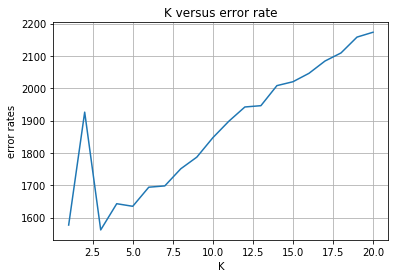

In [406]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_loo.reshape(20,1))
plt.title("K versus error")
plt.ylabel('error rates')
plt.xlabel('K')
plt.grid(True)
plt.show()

### We get minimum error for k=3

### Applying KNN for test images

In [315]:
test_pred=np.empty([10000,20])
for i in range(test.shape[0]):
    test_pred[i]=knn(train,test[i],train_labels,20)

In [316]:
with open('./knn_test_res.p', 'wb') as f:
    pickle.dump(test_pred, f)

In [409]:
#print(test_pred.shape)
error=np.empty([1,20])
for i in range(20):
    error[0,i]=cal_error(test_labels,test_pred[:,i])
print(error)

[[ 309.  373.  295.  318.  312.  323.  306.  330.  341.  335.  332.  339.
   347.  360.  367.  368.  370.  367.  368.  375.]]


### Errors rates for test images

In [386]:
confmat(test_pred[:,2],test_labels)

actual       0     1    2    3    4    5    6    7    8    9
predicted                                                   
0.0        974     0   10    0    1    6    5    0    8    4
1.0          1  1133    9    2    6    1    3   21    2    5
2.0          1     2  996    4    0    0    0    5    4    2
3.0          0     0    2  976    0   11    0    0   16    8
4.0          0     0    0    1  950    2    3    1    8    9
5.0          1     0    0   13    0  859    3    0   11    2
6.0          2     0    0    1    4    5  944    0    3    1
7.0          1     0   13    7    2    1    0  991    4    8
8.0          0     0    2    3    0    3    0    0  914    2
9.0          0     0    0    3   19    4    0   10    4  968


### Confusion matrix for test images (3 nearest neighbour)

# Question 3
# Downsampling

In [318]:

def downsample_singleimage(data,n):
    a=range(0,784,n)
    d=data[a]
    return d.reshape(28,int(d.shape[0]/28))

def downsample_wholedata(data,n):
    a=range(0,784,n)
    d=data[:,a]
    return d
    

In [320]:
n_values_ds=[2,4,7,14]
ds_data_2=downsample_wholedata(train,2)
ds_data_4=downsample_wholedata(train,4)
ds_data_7=downsample_wholedata(train,7)
ds_data_14=downsample_wholedata(train,14)

__Here Leave One Out KNN is performed by passing each train image as test data and set difference train data and each image to the KNN function__ 

In [ ]:
ds_pred_2=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    ds_pred_2[i]=knn(ds_data_2[index,:],ds_data_2[i],train_labels[index],20)

with open('./ds_pred_2.p', 'wb') as f:
    pickle.dump(ds_pred_2, f) 
     

In [410]:
error_ds2=np.empty([1,20])
for i in range(20):
    error_ds2[0,i]=cal_error(train_labels,ds_pred_2[:,i])

print(error_ds2)

with open('./error_ds2.p', 'wb') as f:
    pickle.dump(error_ds2, f)

[[ 1790.  2191.  1798.  1866.  1811.  1888.  1912.  1959.  2015.  2051.
   2066.  2136.  2156.  2216.  2239.  2297.  2333.  2349.  2377.  2407.]]


### Error rates for Leave one out for downsampling n=2

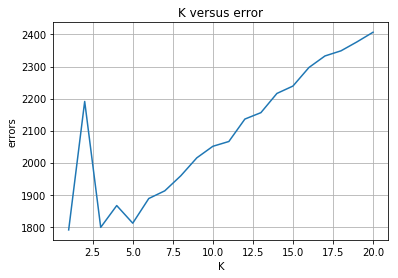

In [412]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_ds2.reshape(20,1))
plt.title("K versus error")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k =1 for n=2

In [ ]:
ds_pred_4=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    ds_pred_4[i]=knn(ds_data_4[index,:],ds_data_4[i],train_labels[index],20)

with open('./ds_pred_4.p', 'wb') as f:
    pickle.dump(ds_pred_4, f) 


In [413]:

error_ds4=np.empty([1,20])
for i in range(20):
    error_ds4[0,i]=cal_error(train_labels,ds_pred_4[:,i])
    
print(error_ds4)


with open('./error_ds4.p', 'wb') as f:
    pickle.dump(error_ds4, f) 

[[ 4209.  4863.  4037.  4156.  4012.  4113.  4136.  4225.  4254.  4338.
   4356.  4448.  4456.  4557.  4591.  4629.  4698.  4728.  4747.  4811.]]


### Error for Leave one out for downsampling n=4

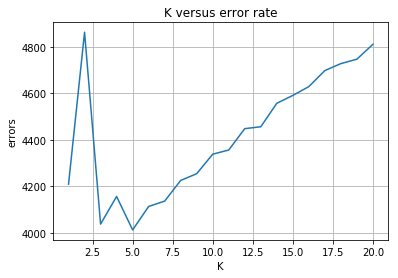

In [414]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_ds4.reshape(20,1))
plt.title("K versus error rate")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k = 5 for n=4

In [ ]:
ds_pred_7=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    ds_pred_7[i]=knn(ds_data_7[index,:],ds_data_7[i],train_labels[index],20)

with open('./ds_pred_7.p', 'wb') as f:
    pickle.dump(ds_pred_7, f)  

In [416]:
with open('./ds_pred_7.p', 'rb') as f:
    ds_pred_7_pickled = pickle.load(f)
    
error_ds7=np.empty([1,20])
for i in range(20):
    error_ds7[0,i]=cal_error(train_labels,ds_pred_7_pickled[:,i])
print(error_ds7)

[[ 10365.  10951.   9449.   9285.   9062.   9114.   9046.   9088.   9056.
    9111.   9127.   9182.   9211.   9257.   9307.   9316.   9341.   9376.
    9448.   9473.]]


### Error  for Leave one out for downsampling n=7

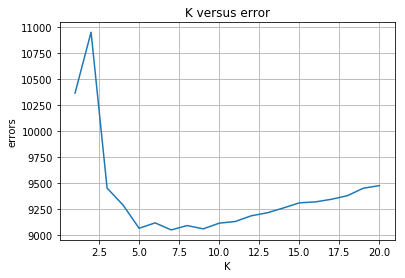

In [417]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_ds7.reshape(20,1))
plt.title("K versus error")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k=7 for n=7

In [ ]:
ds_pred_14=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    ds_pred_14[i]=knn(ds_data_14[index,:],ds_data_14[i],train_labels[index],20)

with open('./ds_pred_14.p', 'wb') as f:
    pickle.dump(ds_pred_14, f) 
    
error_ds14=np.empty([1,20])
for i in range(20):
    error[0,i]=cal_error(train_labels,ds_pred_14[:,i])
print(error_ds14)

with open('./error_ds14.p', 'wb') as f:
    pickle.dump(error_ds14, f) 

In [358]:
with open('./ds_pred_14.p', 'rb') as f:
    ds_pred_14_pickled = pickle.load(f)
    
error_ds14=np.empty([1,20])
for i in range(20):
    error_ds14[0,i]=cal_error(train_labels,ds_pred_14_pickled[:,i])
print(error_ds14)

[[ 19810.  20492.  18022.  17423.  16909.  16751.  16491.  16454.  16378.
   16323.  16306.  16253.  16245.  16206.  16242.  16232.  16248.  16228.
   16267.  16290.]]


### Errors for Leave one out for downsampling n=14

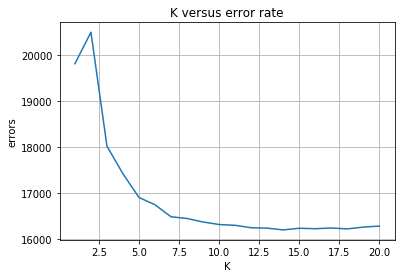

In [380]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_ds14.reshape(20,1))
plt.title("K versus error rate")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k = 14 or n=14

In [361]:
n_values_ds=np.array([2,4,7,14])
err_ds=np.array([error_ds2[0,2],error_ds4[0,4],error_ds7[0,4],error_ds14[0,16]])

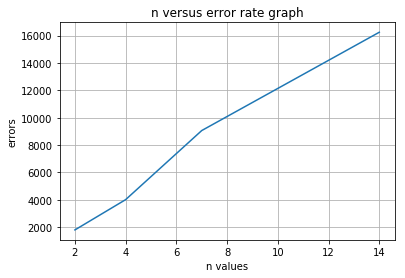

In [381]:
import matplotlib.pyplot as plt
plt.plot(n_values_ds,err_ds)
plt.title("n versus error rate graph")
plt.ylabel('errors')
plt.xlabel('n values')
plt.grid(True)
plt.show()


### n value versus Least error rate graph

* __The best K value increases with the n value.__
* __But the error rate keeps increasing with the n value.__
* __The query time decreases as n value increases.__
* __Classification performance is best in terms of error rate with complete data but query time is huge__

# Question 4
# Downsample_smart

In [325]:
def smart_downsample_singleimage(data,n):
    temp=data
    features=data.shape[0]
    add=n*n
    col=int(features/add)
    #print(type(col))
    import math
    m=int(math.sqrt(col))
    #print(type(m))
    z=np.empty(col)
    j=0
    for i in range(0,784,add):
        y=np.sum(temp[np.arange(i,i+add)])
        z[j]=y
        j+=1
    return z.reshape(m,m)


def smart_downsample_wholedata(data,n):
    temp=data
    features=data.shape[1]
    add=n*n
    col=int(features/add)
    import math
    m=int(math.sqrt(col))
    #print(type(m))
    z=np.empty([data.shape[0],col])
    j=0
    for i in range(0,784,add):
        y=np.sum(temp[:,np.arange(i,i+add)],axis=1)
        z[:,j]=y
        j+=1
    return z

In [ ]:
n_values_ds=[2,4,7,14]
dss_data_2=smart_downsample_wholedata(train,2)
dss_data_4=smart_downsample_wholedata(train,4)
dss_data_7=smart_downsample_wholedata(train,7)
dss_data_14=smart_downsample_wholedata(train,14)

In [328]:
dss_pred_2=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    dss_pred_2[i]=knn(dss_data_2[index,:],dss_data_2[i],train_labels[index],20)

with open('./dss_pred_2.p', 'wb') as f:
    pickle.dump(dss_pred_2, f)     

error_dss2=np.empty([1,20])
for i in range(20):
    error_dss2[0,i]=cal_error(train_labels,dss_pred_2[:,i])
print(error_dss2)


with open('./error_dss2.p', 'wb') as f:
    pickle.dump(error_dss2, f) 



[[ 1942.  2159.  1948.  1957.  2038.  2062.  2131.  2154.  2193.  2224.
   2267.  2332.  2374.  2408.  2472.  2534.  2603.  2640.  2666.  2691.]]


### Error  for Leave one out for smart down sampling n=2

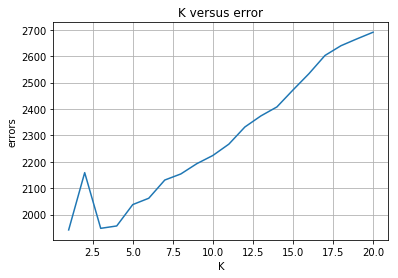

In [418]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_dss2.reshape(20,1))
plt.title("K versus error")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k=1 for n=2

In [ ]:
dss_pred_4=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    dss_pred_4[i]=knn(dss_data_4[index,:],dss_data_4[i],train_labels[index],20)


In [371]:
with open('./dss_pred_4.p', 'wb') as f:
    pickle.dump(dss_pred_4, f)     
    
error_dss4=np.empty([1,20])
for i in range(20):
    error_dss4[0,i]=cal_error(train_labels,dss_pred_4[:,i])
print(error_dss4)

with open('./error_dss4.p', 'wb') as f:
    pickle.dump(error_dss4, f)

[[ 3528.  3940.  3405.  3506.  3460.  3605.  3606.  3704.  3772.  3845.
   3886.  3971.  4031.  4085.  4170.  4233.  4295.  4317.  4382.  4420.]]


### Errors for Leave one out for smart down sampling n=4

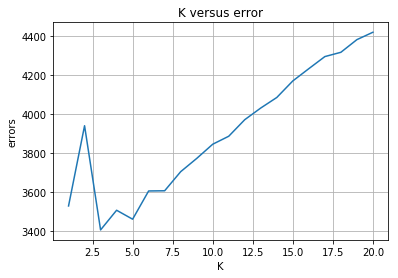

In [419]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_dss4.reshape(20,1))
plt.title("K versus error")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k=3 for n=4

In [331]:
dss_pred_7=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    dss_pred_7[i]=knn(dss_data_7[index,:],dss_data_7[i],train_labels[index],20)

with open('./dss_pred_7.p', 'wb') as f:
    pickle.dump(dss_pred_7, f)     
    
error_dss7=np.empty([1,20])
for i in range(20):
    error_dss7[0,i]=cal_error(train_labels,dss_pred_7[:,i])
print(error_dss7)

with open('./error_dss7.p', 'wb') as f:
    pickle.dump(error_dss7, f) 

[[ 9114.  9843.  8409.  8480.  8216.  8334.  8175.  8304.  8208.  8376.
   8350.  8473.  8511.  8616.  8573.  8674.  8675.  8759.  8731.  8786.]]


### Error  for Leave one out for smart down sampling n=7

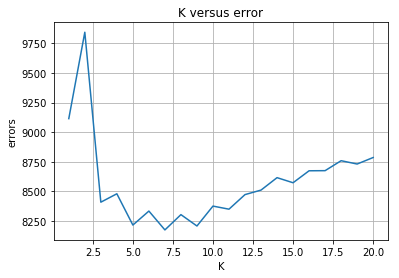

In [420]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_dss7.reshape(20,1))
plt.title("K versus error")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k=7 for n=7

In [333]:
dss_pred_14=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    dss_pred_14[i]=knn(dss_data_14[index,:],dss_data_14[i],train_labels[index],20)
    
with open('./dss_pred_14.p', 'wb') as f:
    pickle.dump(dss_pred_14, f)
    
error_dss14=np.empty([1,20])
for i in range(20):
    error_dss14[0,i]=cal_error(train_labels,dss_pred_14[:,i])
print(error_dss14)

with open('./error_dss14.p', 'wb') as f:
    pickle.dump(error_dss14, f) 

[[ 27300.  27433.  25148.  23951.  23380.  23117.  22764.  22535.  22336.
   22336.  22139.  22129.  22040.  21995.  21917.  21940.  21907.  21830.
   21843.  21834.]]


### Error for Leave one out for smart down sampling n=14

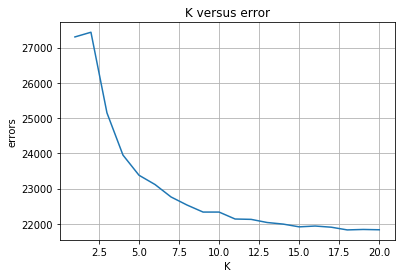

In [421]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_dss14.reshape(20,1))
plt.title("K versus error")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

#### Best k=20 for n=14

In [373]:
n_values_dss=np.array([2,4,7,14])
err_dss=np.array([error_dss2[0,3],error_dss4[0,2],error_dss7[0,6],error_dss14[0,17]])

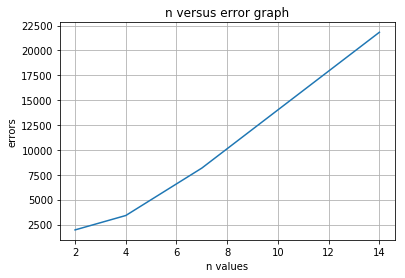

In [422]:
import matplotlib.pyplot as plt
plt.plot(n_values_dss,err_dss)
plt.title("n versus error graph")
plt.ylabel('errors')
plt.grid(True)
plt.xlabel('n values')
plt.show()

### n value versus Least error rate

* __The best k value increases with the n value.__
* __But the error rate keeps increasing with the n value.__
* __The query time decreases as n value increases.__
* __It took 3 hours to run Leave One Out KNN classifer for the whole train data, but it took nearly half hour for downsampled data(n=14)__   

## Question 5
## smart downsampler at n = 28

In [ ]:
dss_data_28=smart_downsample_wholedata(train,28)
dss_pred_28=np.empty([60000,20])
for i in range(60000):
    index=np.setdiff1d(np.arange(60000),i)
    dss_pred_28[i]=knn(dss_data_28[index,:],dss_data_28[i],train_labels[index],20)

In [335]:
with open('./dss_pred28.p', 'wb') as f:
    pickle.dump(dss_pred_28, f) 
error_dss28=np.empty([1,20])
for i in range(20):
    error_dss28[0,i]=cal_error(train_labels,dss_pred_28[:,i])
print(error_dss28)
import pickle
with open('./error_dss28.p', 'wb') as f:
    pickle.dump(error_dss28, f)  

[[ 50132.  48979.  48642.  48643.  48509.  48351.  48199.  48076.  47984.
   47865.  47748.  47766.  47749.  47735.  47647.  47572.  47491.  47455.
   47430.  47445.]]


### Error  for leave one out KNN for downsampled data(n=28)

#### pixel values for label=1

In [336]:
print(dss_data_28[np.where(train_labels==8)][0:5].reshape(1,5))

[[ 27106.  32565.  28305.  23182.  32367.]]


#### pixel values for label=8

In [337]:
print(dss_data_28[np.where(train_labels==1)][0:5].reshape(1,5))

[[ 17135.  17646.  10874.  11622.  16577.]]


#### Label 8 has darker pixel than label 1

In [338]:
with open('./error_dss28.p', 'rb') as f:
    error_dss28_pickled = pickle.load(f)

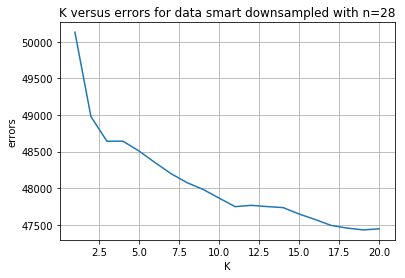

In [423]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1,21),error_dss28.reshape(20,1))
plt.title("K versus errors for data smart downsampled with n=28")
plt.ylabel('errors')
plt.xlabel('K')
plt.grid(True)
plt.show()

* __As k increases, error rate decreases for smart downsampled data (n=28) __
* __Query time for downsampled data is reduced compared to whole data.__
* __Query time for whole data was 3 hours and for downsampled data, it was around 20 minutes__
* __But the error rate has increased enormously__
* __Best Least Error  for whole data is 1562 where as for downsampled data (n=28), it is 47430__


## Question 6

* __From the above downsampling experiments, it is clear that  images of each class lose their exclusivity, which leads to poor classification.__
* __In my transformation function I tried to reduce the dimensions of the data without the images losing their basis shape__
* __Every Image in MNIST dataset has borders of zeros, which can be removed.__ 
* __My  transform function trims the image from 784 dimensions to 380 dimensions__

### Image before trimming

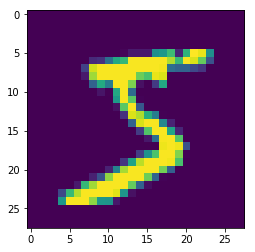

In [340]:
plt.imshow(train[0].reshape(28,28))
plt.show()

### Image after trimming

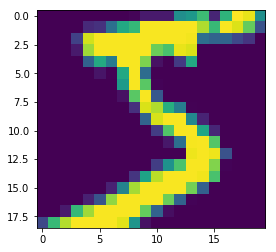

In [342]:
temp=train[0]
temp=np.delete(temp,np.arange(783,671,-1))
temp=np.delete(temp,range(0,140))
temp=temp.reshape(19,28)
temp=np.delete(temp,range(27,23,-1),1)
temp=np.delete(temp,range(0,4),1)
plt.imshow(temp.reshape(19,20))
plt.show()

#### Later after trimming, I changed every non zero dimensions to 1.This has further reduced the query time of the classification.

In [343]:
def transform(data):
    temp=data
    #print(temp.shape)
    temp=np.delete(temp,np.arange(783,671,-1))
    temp=np.delete(temp,range(0,140))
    #print(temp.shape)
    temp[np.where(temp>0)]=1
    temp=temp.reshape(19,28)
    temp=np.delete(temp,range(27,23,-1),1)
    temp=np.delete(temp,range(0,4),1)
    temp=temp.reshape(1,380)
    return temp

#### Transforming train and test images

In [344]:
out=np.empty([60000,380])
for i in range(train.shape[0]):
    out[i]=transform(train[i])
    
testout=np.empty([10000,380])
for i in range(test.shape[0]):
    testout[i]=transform(test[i])

#### Applying Leave One Out knn classification to test images after transformation

In [ ]:
testpred_transformed=np.empty([10000,20])

for i in range(testout.shape[0]):
    testpred_transformed[i]=knn(out,testout[i],train_labels,20)

error_t=np.empty([1,20])
for i in range(20):
    error_t[0,i]=cal_error(test_labels,testpred_transformed[:,i])
print(error_t)

In [ ]:
with open('./testpred_transformedP.p', 'wb') as y:
    pickle.dump(testpred_transformed,y) 

In [348]:
with open('./testpred_transformedP.p', 'rb') as y:
    testpred_transformed = pickle.load(y)

#### Error rates for test images after applying transformation

In [349]:
error_t=np.empty([1,20])
for i in range(20):
    error_t[0,i]=cal_error(test_labels,testpred_transformed[:,i])
print(error_t)

[[ 371.  411.  381.  362.  364.  358.  378.  384.  390.  389.  389.  393.
   396.  392.  399.  397.  407.  412.  413.  417.]]


* __The best error is 295  for k =3 without transformation.__
* __The best error is 358  for k =6 with transformation.__
* __Errors have increased after transformation__
* __The query time without transformation for test images was approximately half hour.__
* __The query time with transformation for test images was approximately 20 minutes.__ 
* __So the query time has decreased with transformation.__
